In [ ]:
import os
import cv2
from transformers import pipeline
from PIL import Image
import requests
import numpy as np
from tqdm import tqdm

In [ ]:
# Cell 1: ================= Dataset config values =================

histogram_threshold = 1500
dataset_output_name = "dataset_0703"

# =========================================================


In [ ]:
# (Mounting Google Drive to access the stored datasets)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Load depth estimation pipeline
depth_estimation_pipeline = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf", trust_remote_code=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [ ]:
# Cell 3: Define dataset directories and subfolders

datasets_directory = "/content/drive/MyDrive/Colab_Notebooks/datasets/"
provided_datasets_folder = "provided_datasets/"
provided_datasets_subfolders = [
    "cyberzoo_aggressive_flight/20190121-144646/",
    "cyberzoo_canvas_approach/20190121-151448/",
    "cyberzoo_poles/20190121-135009/",
    "cyberzoo_poles_panels/20190121-140205/",
    "cyberzoo_poles_panels_mats/20190121-142935/",
]

collected_datasets_folder = "collected_datasets/"
collected_datasets_subfolders = os.listdir(datasets_directory + collected_datasets_folder)


In [ ]:
# Cell 4: Gather image paths from all dataset folders

all_image_paths = []
all_dataset_folders = []
#all_dataset_folders.extend([datasets_directory + provided_datasets_folder + subfolder for subfolder in provided_datasets_subfolders])
all_dataset_folders.extend([datasets_directory + collected_datasets_folder + subfolder + '/' for subfolder in collected_datasets_subfolders])

for folder_path in all_dataset_folders:
    print(f"Collecting images from: {folder_path}")
    image_files = [folder_path + img for img in os.listdir(folder_path) if img.endswith(".jpg")]
    all_image_paths.extend(image_files)


In [ ]:
# Cell 5: Print total number of image files
print(f"Total number of image files: {len(all_image_paths)}")


Total number of image files: 4358


In [ ]:
# Cell 6: Function to get label based on depth histogram of the image patch
def get_label(datapoint):
    # Calculate the histogram
    hist_values, bin_edges = np.histogram(datapoint.ravel(), bins=5, range=(0, 255))
    # Return True if the highest bin exceeds the threshold
    new_label = hist_values[-1] > histogram_threshold
    return new_label


In [ ]:
# Cell 7: Process each image and extract patches
dataset_list = []

# Note: This code does not properly utilize the GPU due to the pipeline used,
# which causes the model to take much longer than necessary to process the dataset.

for image_filepath in tqdm(all_image_paths):
    # Open image
    input_image = Image.open(image_filepath)

    # Rotate image to horizontal orientation
    input_image = input_image.rotate(90, expand=True)

    # Calculate depth map for the entire image
    depth_map = depth_estimation_pipeline(input_image)["depth"]

    # Crop the 3 image patches from the depth map
    # Patches are collected as 170x170 images, later reduced to 85x85
    depth_patch_left = np.asarray(depth_map.crop((0, 35, 170, 205)))
    depth_patch_center = np.asarray(depth_map.crop((170, 35, 340, 205)))
    depth_patch_right = np.asarray(depth_map.crop((340, 35, 510, 205)))

    # Crop the 3 corresponding image patches from the RGB image
    rgb_patch_left = input_image.crop((0, 35, 170, 205))
    rgb_patch_center = input_image.crop((170, 35, 340, 205))
    rgb_patch_right = input_image.crop((340, 35, 510, 205))

    # Get the label for each patch based on the depth map
    label_left = get_label(depth_patch_left)
    label_center = get_label(depth_patch_center)
    label_right = get_label(depth_patch_right)

    data_point_left = {
        "filename": image_filepath,
        "depth": depth_patch_left,
        "image": rgb_patch_left,
        "label": label_left
    }

    data_point_center = {
        "filename": image_filepath,
        "depth": depth_patch_center,
        "image": rgb_patch_center,
        "label": label_center
    }

    data_point_right = {
        "filename": image_filepath,
        "depth": depth_patch_right,
        "image": rgb_patch_right,
        "label": label_right
    }

    # Store each patch as its own data point in the dataset list
    dataset_list.append(data_point_left)
    dataset_list.append(data_point_center)
    dataset_list.append(data_point_right)


100%|██████████| 4358/4358 [1:04:15<00:00,  1.13it/s]


In [ ]:
# Cell 8: Print dataset statistics
print(f"Total dataset size: {len(dataset_list)}")
# Dataset is quite imbalanced; print count of positive labels
print(f"Number of true labels: {len([x for x in dataset_list if x['label'] == True])}")


Total dataset size: 13074
Number of true labels: 4338


True


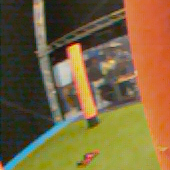

In [ ]:
# Cell 9: Inspect an image patch from the dataset
i = 9000
print(dataset_list[i]['label'])
dataset_list[i]['image']


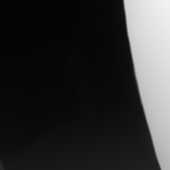

In [ ]:
# Cell 10: Show the depth map patch corresponding to the inspected image
Image.fromarray(np.uint8(dataset_list[i]['depth']))


In [ ]:
# Cell 11: Save the dataset as a pickle file
import pickle

with open(dataset_output_name + '.pkl', 'wb') as f:
    pickle.dump(dataset_list, f)
